In [39]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2_contingency
import os
import warnings
warnings.filterwarnings('ignore')

import lime
import lime.lime_tabular
import shap

from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [40]:

def read_csv_files(folder):
    dfs = []
    for filename in os.listdir(folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(folder, filename)
            df = pd.read_csv(filepath)
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

biflow_features = read_csv_files('biflow')


In [41]:
biflow_features.head()

,ip_src,ip_dst,prt_src,prt_dst,proto,fwd_num_pkts,bwd_num_pkts,fwd_mean_iat,bwd_mean_iat,fwd_std_iat,...,bwd_max_pkt_len,fwd_num_bytes,bwd_num_bytes,fwd_num_psh_flags,bwd_num_psh_flags,fwd_num_rst_flags,bwd_num_rst_flags,fwd_num_urg_flags,bwd_num_urg_flags,is_attack
0,192.168.2.5,192.168.2.1,46279,53,17,2,2,0.000008,0.000016,0.0,...,83.0,166,166,0,0,0,0,0,0,1
1,192.168.2.7,192.168.2.1,57171,53,17,1,1,0.000000,0.000000,0.0,...,76.0,87,76,0,0,0,0,0,0,0
2,192.168.2.7,192.168.2.1,33953,53,17,1,1,0.000000,0.000000,0.0,...,76.0,87,76,0,0,0,0,0,0,0
3,192.168.2.6,192.168.2.1,37765,53,17,2,2,0.000007,0.000020,0.0,...,67.0,134,134,0,0,0,0,0,0,0
4,192.168.2.7,192.168.2.1,49931,53,17,1,1,0.000000,0.000000,0.0,...,60.0,71,60,0,0,0,0,0,0,0


In [42]:
biflow_features.is_attack.value_counts()

is_attack
0    188378
1     71001
Name: count, dtype: int64

In [43]:
biflow_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259379 entries, 0 to 259378
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ip_src             259379 non-null  object 
 1   ip_dst             259379 non-null  object 
 2   prt_src            259379 non-null  int64  
 3   prt_dst            259379 non-null  int64  
 4   proto              259379 non-null  int64  
 5   fwd_num_pkts       259379 non-null  int64  
 6   bwd_num_pkts       259379 non-null  int64  
 7   fwd_mean_iat       259379 non-null  float64
 8   bwd_mean_iat       259379 non-null  float64
 9   fwd_std_iat        259379 non-null  float64
 10  bwd_std_iat        259379 non-null  float64
 11  fwd_min_iat        259379 non-null  float64
 12  bwd_min_iat        259379 non-null  float64
 13  fwd_max_iat        259379 non-null  float64
 14  bwd_max_iat        259379 non-null  float64
 15  fwd_mean_pkt_len   259379 non-null  float64
 16  bw

In [44]:
normal_dataset = biflow_features[biflow_features['is_attack'] == 0]
malicious_dataset = biflow_features[biflow_features['is_attack'] == 1]

In [45]:
print("Shape of Normal dataset:", normal_dataset.shape)
print("Shape of Malicious dataset:", malicious_dataset.shape)

Shape of Normal dataset: (188378, 32)
Shape of Malicious dataset: (71001, 32)


In [46]:
normal_dataset = normal_dataset.drop(['ip_src', 'ip_dst', 'prt_src', 'prt_dst', 'proto', 'is_attack'], axis=1)
malicious_dataset = malicious_dataset.drop(['ip_src', 'ip_dst', 'prt_src', 'prt_dst', 'proto', 'is_attack'], axis=1)

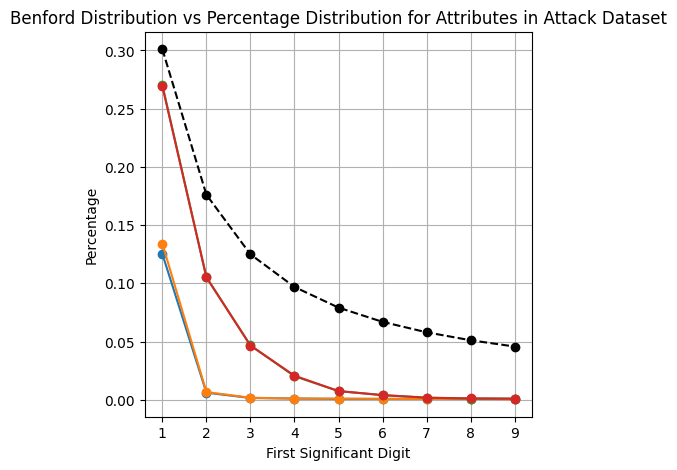

In [47]:
# Function to extract first significant digit and handle zero values
def extract_first_significant_digit(flow_size_diff):
    first_digits = []
    for diff in flow_size_diff:
        if diff == 0:
            continue
        first_digit = int(str(diff)[0])
        first_digits.append(first_digit)
    return first_digits

# Define the function to calculate flow size difference
def calculate_flow_size_difference(flow_sizes):
    flow_size_difference = []
    for i in range(1, len(flow_sizes)):
        difference = abs(flow_sizes[i] - flow_sizes[i-1])
        flow_size_difference.append(difference)
    return flow_size_difference

# Function to calculate percentage distribution
def calculate_percentage_distribution(flow_size_diff):
    first_digits = extract_first_significant_digit(flow_size_diff)
    first_digit_counts = np.bincount(first_digits)[1:]
    
    # Pad the attack flow count with zeros if needed to ensure both arrays have the same length
    if len(first_digit_counts) < 9:
        first_digit_counts = np.pad(first_digit_counts, (0, 9 - len(first_digit_counts)), 'constant')
        
    return first_digit_counts / len(first_digits)

# Define the function to calculate Inverse-Benford distribution
def benford_distribution(d):
    return math.log10(1 + 1 / d)

# Calculate Inverse-Benford distribution for each digit
benford_distribution_values = [benford_distribution(d) for d in range(1, 10)]

attributes = [
    'fwd_mean_iat',
    'bwd_mean_iat',
    'fwd_std_iat',
    'bwd_std_iat'
]

plt.figure(figsize=(5, 5))

for i, attribute in enumerate(attributes):
    data_attack = malicious_dataset[attribute]
    flow_size_diff = calculate_flow_size_difference(np.array(data_attack))
    percentage_distribution = calculate_percentage_distribution(flow_size_diff)

    plt.plot(range(1, 10), percentage_distribution, marker='o',linestyle='-', label=f'{attribute}')

plt.plot(range(1, 10), benford_distribution_values, marker='o', color='black', linestyle='--', label="Benford's Distribution")
plt.title("Benford Distribution vs Percentage Distribution for Attributes in Attack Dataset")
plt.xlabel("First Significant Digit")
plt.ylabel("Percentage")
plt.xticks(range(1, 10))
plt.grid(True)
plt.show()


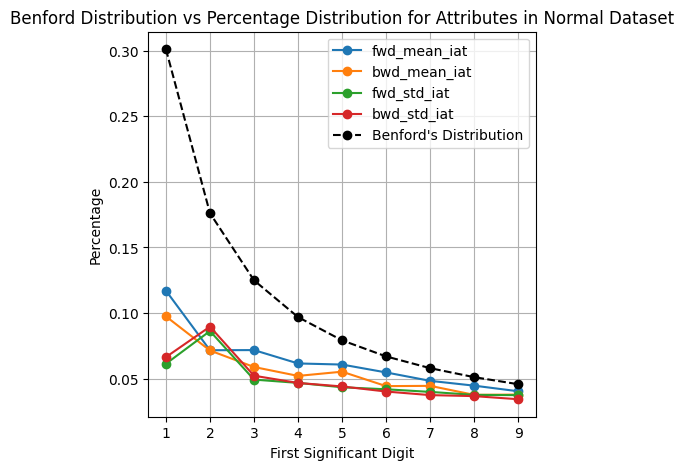

In [48]:
plt.figure(figsize=(5, 5))

for i, attribute in enumerate(attributes):
    data_normal = normal_dataset[attribute]
    flow_size_diff = calculate_flow_size_difference(np.array(data_normal))
    percentage_distribution = calculate_percentage_distribution(flow_size_diff)

    plt.plot(range(1, 10), percentage_distribution, marker='o', label=f'{attribute}')

plt.plot(range(1, 10), benford_distribution_values, marker='o', color='black', linestyle='--', label="Benford's Distribution")
plt.title("Benford Distribution vs Percentage Distribution for Attributes in Normal Dataset")
plt.xlabel("First Significant Digit")
plt.ylabel("Percentage")
plt.xticks(range(1, 10))
plt.grid(True)
plt.legend()
plt.show()

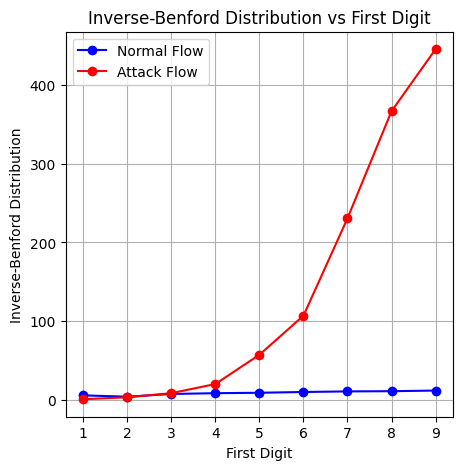

In [49]:


# Calculate flow size difference for normal and attack flows
flow_size_diff_normal = calculate_flow_size_difference(np.array(normal_dataset['bwd_std_iat']))
flow_size_diff_attack = calculate_flow_size_difference(np.array(malicious_dataset['bwd_std_iat']))


# Extract first significant digit and handle zero values for normal and attack flows
first_digits_normal = extract_first_significant_digit(flow_size_diff_normal)
first_digits_attack = extract_first_significant_digit(flow_size_diff_attack)

# Calculate frequency distribution of first significant digits for normal and attack flows
first_digit_counts_normal = np.bincount(first_digits_normal)[1:]
first_digit_counts_attack = np.bincount(first_digits_attack)[1:]

# Pad the attack flow count with zeros if needed to ensure both arrays have the same length
if len(first_digit_counts_attack) < 9:
    first_digit_counts_attack = np.pad(first_digit_counts_attack, (0, 9 - len(first_digit_counts_attack)), 'constant')

# Calculate percentage distribution for normal and attack flows
percentage_distribution_normal = (first_digit_counts_normal / len(first_digits_normal))
percentage_distribution_attack = (first_digit_counts_attack / len(first_digits_attack))

# Define the function to calculate Inverse-Benford distribution
def inverse_benford_distribution(frequency):
    return 1 / (10**(frequency) - 1)

# Calculate Inverse-Benford distribution for each digit
inverse_benford_distribution_values_normal = [inverse_benford_distribution(f) for f in percentage_distribution_normal]
inverse_benford_distribution_values_attack = [inverse_benford_distribution(f) for f in percentage_distribution_attack]

# Plot the Inverse-Benford distribution
plt.figure(figsize=(5, 5))
plt.plot(range(1, 10), inverse_benford_distribution_values_normal, marker='o', color='blue', label='Normal Flow')
plt.plot(range(1, 10), inverse_benford_distribution_values_attack, marker='o', color='red', label='Attack Flow')
plt.title("Inverse-Benford Distribution vs First Digit")
plt.xlabel("First Digit")
plt.ylabel("Inverse-Benford Distribution")
plt.xticks(range(1, 10))
plt.grid(True)
plt.legend(loc='best')
plt.savefig('inverse_benford_distribution_plot.png', bbox_inches='tight', dpi=400)
plt.show()


In [50]:
# Define the function to calculate Inverse-Benford distribution
def inverse_benford_distribution(frequency):
    return 1 / (10**(frequency) - 1)

attributes = [
    'fwd_mean_iat',
    'bwd_mean_iat',
    'fwd_std_iat',
    'bwd_std_iat'
]

def calculate_inverse_benford_distribution(data_normal, data_attack):
    # Calculate flow size difference for normal and attack flows
    flow_size_diff_normal = calculate_flow_size_difference(np.array(data_normal))
    flow_size_diff_attack = calculate_flow_size_difference(np.array(data_attack))

    # Extract first significant digit and handle zero values for normal and attack flows
    first_digits_normal = extract_first_significant_digit(flow_size_diff_normal)
    first_digits_attack = extract_first_significant_digit(flow_size_diff_attack)

    # Calculate frequency distribution of first significant digits for normal and attack flows
    first_digit_counts_normal = np.bincount(first_digits_normal)[1:]
    first_digit_counts_attack = np.bincount(first_digits_attack)[1:]

    # Pad the attack flow count with zeros if needed to ensure both arrays have the same length
    if len(first_digit_counts_normal) < 9:
        first_digit_counts_normal = np.pad(first_digit_counts_normal, (0, 9 - len(first_digit_counts_normal)), 'constant')
    
    # Pad the attack flow count with zeros if needed to ensure both arrays have the same length
    if len(first_digit_counts_attack) < 9:
        first_digit_counts_attack = np.pad(first_digit_counts_attack, (0, 9 - len(first_digit_counts_attack)), 'constant')

    # Calculate percentage distribution for normal and attack flows
    percentage_distribution_normal = (first_digit_counts_normal / len(first_digits_normal))
    percentage_distribution_attack = (first_digit_counts_attack / len(first_digits_attack))

    # Calculate Inverse-Benford distribution for each digit
    inverse_benford_distribution_values_normal = [inverse_benford_distribution(f) for f in percentage_distribution_normal]
    inverse_benford_distribution_values_attack = [inverse_benford_distribution(f) for f in percentage_distribution_attack]

    return inverse_benford_distribution_values_normal, inverse_benford_distribution_values_attack


plt.figure(figsize=(5, 5))

for i, attribute in enumerate(attributes):
    data_normal = normal_dataset[attribute]
    data_attack = malicious_dataset[attribute]
    
    inverse_benford_distribution_values_normal, inverse_benford_distribution_values_attack = calculate_inverse_benford_distribution(data_normal, data_attack)
    
    plt.plot(range(1, 10), inverse_benford_distribution_values_normal, marker='o',linestyle='-', linewidth=3, color='blue', label='Normal Flow')
    plt.plot(range(1, 10), inverse_benford_distribution_values_attack, marker='o',linestyle='-', linewidth=3, color='red', label='Attack Flow')
    plt.title(f"Inverse-Benford Distribution for {attribute}")
    plt.xlabel("First Digit")
    plt.ylabel("Inverse-Benford Distribution")
    plt.xticks(range(1, 10))
    plt.grid(True)
    plt.legend(loc='best')
    
    # Save each plot
    plt.savefig(f'inverse_benford_distribution_plot_biflow_{attribute}.png', bbox_inches='tight', dpi=400)
    plt.clf()

# Save the combined plot
plt.tight_layout()
plt.savefig('inverse_benford_distribution_plots_biflow.png', bbox_inches='tight', dpi=400)
plt.show()


<Figure size 500x500 with 0 Axes>

In [51]:
def calculate_inverse_benford_distribution(data_normal):
    # Calculate flow size difference for normal and attack flows
    flow_size_diff_normal = calculate_flow_size_difference(np.array(data_normal))

    # Extract first significant digit and handle zero values for normal and attack flows
    first_digits_normal = extract_first_significant_digit(flow_size_diff_normal)

    # Calculate frequency distribution of first significant digits for normal and attack flows
    first_digit_counts_normal = np.bincount(first_digits_normal)[1:]

    # Pad the attack flow count with zeros if needed to ensure both arrays have the same length
    if len(first_digit_counts_normal) < 9:
        first_digit_counts_normal = np.pad(first_digit_counts_normal, (0, 9 - len(first_digit_counts_normal)), 'constant')

    # Calculate percentage distribution for normal and attack flows
    percentage_distribution_normal = (first_digit_counts_normal / len(first_digits_normal))

    # Calculate Inverse-Benford distribution for each digit
    inverse_benford_distribution_values_normal = [inverse_benford_distribution(f) for f in percentage_distribution_normal]

    return inverse_benford_distribution_values_normal

In [52]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Train the attribute using the 100% normal dataset
def train_attribute(normal_dataset, attribute):
    X_train = np.array(range(1, 10)).reshape(-1, 1)
    y_train = calculate_inverse_benford_distribution(normal_dataset[attribute].sample(n=5000, replace=False))
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    return regressor

# Function to generate datasets with different percentages of normal and attack traffic
def generate_datasets(normal_dataset, malicious_dataset, attribute, normal_percentage):
    normal_samples = int(5000 * normal_percentage)
    attack_samples = 5000 - normal_samples
    
    normal_data = normal_dataset.sample(n=normal_samples, replace=False)
    attack_data = malicious_dataset.sample(n=attack_samples, replace=False)
    
    return pd.concat([normal_data, attack_data])

threshold_mae = 0.1
threshold_mse = 0.05
threshold_rmse = 0.07

# Create an empty DataFrame to store error metrics
error_metrics_df = pd.DataFrame(columns=['Attribute', 'Normal Percentage', 'MAE', 'MSE', 'RMSE'])

# Dictionary to store trained models
trained_models = {}

# Train the models with the complete normal dataset
for attribute in attributes:
    trained_models[attribute] = train_attribute(normal_dataset, attribute)

# Evaluate datasets with different percentages of normal and attack traffic
for normal_percentage in [1.0, 0.7, 0.5, 0.3, 0.0]:
    error_metrics_df_ratio = pd.DataFrame(columns=['Attribute', 'Normal Percentage', 'MAE', 'MSE', 'RMSE'])
    for attribute in attributes:
        trained_attribute = trained_models[attribute]
        dataset = generate_datasets(normal_dataset, malicious_dataset, attribute, normal_percentage)
        
        # Calculate inverse Benford distribution for the generated dataset
        X_test = np.array(range(1, 10)).reshape(-1, 1)
        y_test = calculate_inverse_benford_distribution(dataset[attribute])
        
        # Predict using the trained attribute
        y_pred = trained_attribute.predict(X_test)
        
        # Calculate error metrics
        error_metrics = {
            'MAE': np.mean(np.abs(y_test - y_pred)),
            'MSE': np.mean((y_test - y_pred)**2),
            'RMSE': np.sqrt(np.mean((y_test - y_pred)**2))
        }
        
        # Classify flows based on error metrics
        classification = "Normal Flow" if all(error_metrics[metric] < threshold for metric, threshold in zip(['MAE', 'MSE', 'RMSE'], [threshold_mae, threshold_mse, threshold_rmse])) else "Attack Flow"
        
        # Append error metrics to DataFrame
        error_metrics_df_ratio = pd.concat([error_metrics_df_ratio, pd.DataFrame([{'Attribute': attribute,
                                                                                    'Normal Percentage': f"{int(normal_percentage * 100)}%",
                                                                                    'MAE': error_metrics['MAE'],
                                                                                    'MSE': error_metrics['MSE'],
                                                                                    'RMSE': error_metrics['RMSE']}])])
    print(f"\nError Metrics for Normal Percentage: {int(normal_percentage * 100)}%")
    print(error_metrics_df_ratio)



Error Metrics for Normal Percentage: 100%
      Attribute Normal Percentage       MAE       MSE      RMSE
0  fwd_mean_iat              100%  1.292008  2.200353  1.483359
0  bwd_mean_iat              100%  1.364173  3.087210  1.757046
0   fwd_std_iat              100%  2.162508  6.448028  2.539297
0   bwd_std_iat              100%  2.254279  6.963138  2.638776

Error Metrics for Normal Percentage: 70%
      Attribute Normal Percentage       MAE        MSE      RMSE
0  fwd_mean_iat               70%  3.531500  16.184860  4.023041
0  bwd_mean_iat               70%  4.405509  26.837651  5.180507
0   fwd_std_iat               70%  4.491287  27.612500  5.254760
0   bwd_std_iat               70%  4.713402  28.725198  5.359589

Error Metrics for Normal Percentage: 50%
      Attribute Normal Percentage       MAE         MSE       RMSE
0  fwd_mean_iat               50%  4.073117   24.103788   4.909561
0  bwd_mean_iat               50%  5.190211   38.616717   6.214235
0   fwd_std_iat            

In [53]:
uniflow_features = read_csv_files('uniflow')

In [54]:
uniflow_features.head()

,ip_src,ip_dst,prt_src,prt_dst,proto,num_pkts,mean_iat,std_iat,min_iat,max_iat,mean_pkt_len,num_bytes,num_psh_flags,num_rst_flags,num_urg_flags,std_pkt_len,min_pkt_len,max_pkt_len,is_attack
0,192.168.2.5,192.168.2.1,46279,53,17,2,0.000008,0.000000,0.000008,0.000008,83.0,166,0,0,0,0.0,83.0,83.0,1
1,192.168.2.1,192.168.2.5,53,46279,17,2,0.000016,0.000000,0.000016,0.000016,83.0,166,0,0,0,0.0,83.0,83.0,1
2,192.168.2.5,8.8.8.8,53405,53,17,2,0.000005,0.000000,0.000005,0.000005,83.0,166,0,0,0,0.0,83.0,83.0,1
3,10.0.0.23,192.168.2.7,47103,1234,17,23917,0.090139,0.060855,0.000002,0.166959,1344.0,32144448,0,0,0,0.0,1344.0,1344.0,0
4,192.168.2.7,8.8.8.8,60528,53,6,1,0.000000,0.000000,0.000000,0.000000,60.0,60,0,0,0,0.0,60.0,60.0,0


In [55]:
uniflow_features.is_attack.value_counts()

is_attack
0    376186
1    119339
Name: count, dtype: int64

In [56]:
uniflow_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495525 entries, 0 to 495524
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ip_src         495525 non-null  object 
 1   ip_dst         495525 non-null  object 
 2   prt_src        495525 non-null  int64  
 3   prt_dst        495525 non-null  int64  
 4   proto          495525 non-null  int64  
 5   num_pkts       495525 non-null  int64  
 6   mean_iat       495525 non-null  float64
 7   std_iat        495525 non-null  float64
 8   min_iat        495525 non-null  float64
 9   max_iat        495525 non-null  float64
 10  mean_pkt_len   495525 non-null  float64
 11  num_bytes      495525 non-null  int64  
 12  num_psh_flags  495525 non-null  int64  
 13  num_rst_flags  495525 non-null  int64  
 14  num_urg_flags  495525 non-null  int64  
 15  std_pkt_len    495525 non-null  float64
 16  min_pkt_len    495525 non-null  float64
 17  max_pkt_len    495525 non-nul

In [57]:
normal_dataset = uniflow_features[uniflow_features['is_attack'] == 0]
malicious_dataset = uniflow_features[uniflow_features['is_attack'] == 1]

In [58]:
print("Shape of Normal dataset:", normal_dataset.shape)
print("Shape of Malicious dataset:", malicious_dataset.shape)

Shape of Normal dataset: (376186, 19)
Shape of Malicious dataset: (119339, 19)


In [59]:
normal_dataset = normal_dataset.drop(['ip_src', 'ip_dst', 'prt_src', 'prt_dst', 'proto', 'is_attack'], axis=1)
malicious_dataset = malicious_dataset.drop(['ip_src', 'ip_dst', 'prt_src', 'prt_dst', 'proto', 'is_attack'], axis=1)

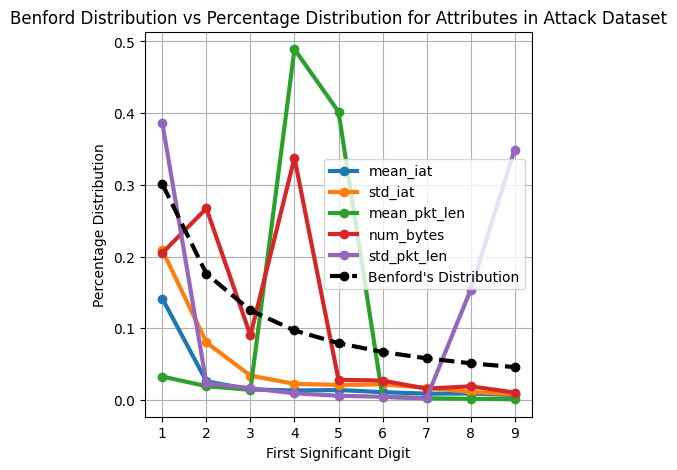

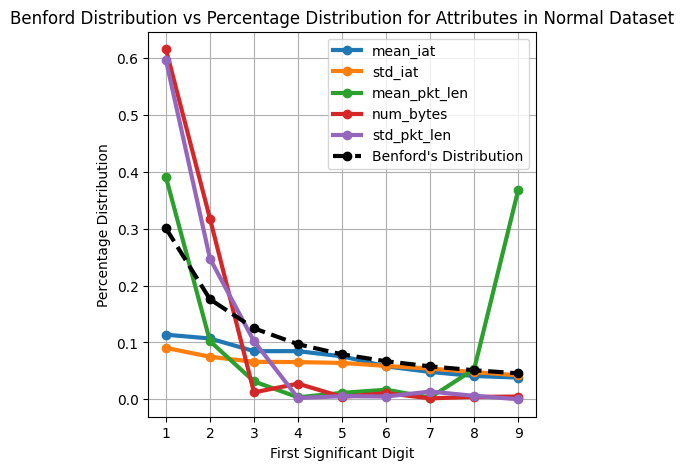

In [60]:
# Define the function to calculate flow size difference
def calculate_flow_size_difference(flow_sizes):
    flow_size_difference = []
    for i in range(1, len(flow_sizes)):
        difference = abs(flow_sizes[i] - flow_sizes[i-1])
        flow_size_difference.append(difference)
    return flow_size_difference

# Function to calculate percentage distribution
def calculate_percentage_distribution(flow_size_diff):
    first_digits = extract_first_significant_digit(flow_size_diff)
    first_digit_counts = np.bincount(first_digits)[1:]
    
    # Pad the attack flow count with zeros if needed to ensure both arrays have the same length
    if len(first_digit_counts) < 9:
        first_digit_counts = np.pad(first_digit_counts, (0, 9 - len(first_digit_counts)), 'constant')
        
    return first_digit_counts / len(first_digits)

attributes = ['mean_iat', 'std_iat', 'mean_pkt_len', 'num_bytes', 'std_pkt_len']

plt.figure(figsize=(5, 5))

for i, attribute in enumerate(attributes):
    data_attack = malicious_dataset[attribute]
    flow_size_diff = calculate_flow_size_difference(np.array(data_attack))
    percentage_distribution = calculate_percentage_distribution(flow_size_diff)

    plt.plot(range(1, 10), percentage_distribution, marker='o', label=f'{attribute}', linewidth=3)

plt.plot(range(1, 10), benford_distribution_values, marker='o', color='black', linestyle='--',linewidth=3, label="Benford's Distribution")
plt.title("Benford Distribution vs Percentage Distribution for Attributes in Attack Dataset")
plt.xlabel("First Significant Digit")
plt.ylabel("Percentage Distribution")
plt.xticks(range(1, 10))
plt.grid(True)
plt.legend(loc='best')
plt.savefig('benford_distribution_plot_uni_attack.png',bbox_inches='tight', dpi=400)
plt.show()


plt.figure(figsize=(5, 5))

for i, attribute in enumerate(attributes):
    data_normal = normal_dataset[attribute]
    flow_size_diff = calculate_flow_size_difference(np.array(data_normal))
    percentage_distribution = calculate_percentage_distribution(flow_size_diff)

    plt.plot(range(1, 10), percentage_distribution, marker='o', label=f'{attribute}', linewidth=3)

plt.plot(range(1, 10), benford_distribution_values, marker='o', color='black', linestyle='--',linewidth=3, label="Benford's Distribution")
plt.title("Benford Distribution vs Percentage Distribution for Attributes in Normal Dataset")
plt.xlabel("First Significant Digit")
plt.ylabel("Percentage Distribution")
plt.xticks(range(1, 10))
plt.grid(True)
plt.legend(loc='best')
plt.savefig('benford_distribution_plot_uni_normal.png',bbox_inches='tight', dpi=400)
plt.show()



In [63]:
# Define the function to calculate Inverse-Benford distribution
def inverse_benford_distribution(frequency):
    return 1 / (10**(frequency) - 1)

def calculate_inverse_benford_distribution(data_normal, data_attack):
    # Calculate flow size difference for normal and attack flows
    flow_size_diff_normal = calculate_flow_size_difference(np.array(data_normal))
    flow_size_diff_attack = calculate_flow_size_difference(np.array(data_attack))

    # Extract first significant digit and handle zero values for normal and attack flows
    first_digits_normal = extract_first_significant_digit(flow_size_diff_normal)
    first_digits_attack = extract_first_significant_digit(flow_size_diff_attack)

    # Calculate frequency distribution of first significant digits for normal and attack flows
    first_digit_counts_normal = np.bincount(first_digits_normal)[1:]
    first_digit_counts_attack = np.bincount(first_digits_attack)[1:]

    # Pad the attack flow count with zeros if needed to ensure both arrays have the same length
    if len(first_digit_counts_normal) < 9:
        first_digit_counts_normal = np.pad(first_digit_counts_normal, (0, 9 - len(first_digit_counts_normal)), 'constant')
    
    # Pad the attack flow count with zeros if needed to ensure both arrays have the same length
    if len(first_digit_counts_attack) < 9:
        first_digit_counts_attack = np.pad(first_digit_counts_attack, (0, 9 - len(first_digit_counts_attack)), 'constant')

    # Calculate percentage distribution for normal and attack flows
    percentage_distribution_normal = (first_digit_counts_normal / len(first_digits_normal))
    percentage_distribution_attack = (first_digit_counts_attack / len(first_digits_attack))

    # Calculate Inverse-Benford distribution for each digit
    inverse_benford_distribution_values_normal = [inverse_benford_distribution(f) for f in percentage_distribution_normal]
    inverse_benford_distribution_values_attack = [inverse_benford_distribution(f) for f in percentage_distribution_attack]

    return inverse_benford_distribution_values_normal, inverse_benford_distribution_values_attack

attributes = ['mean_iat', 'std_iat', 'mean_pkt_len', 'num_bytes', 'std_pkt_len']

plt.figure(figsize=(5, 5))

for i, attribute in enumerate(attributes):
    data_normal = normal_dataset[attribute]
    data_attack = malicious_dataset[attribute]
    
    inverse_benford_distribution_values_normal, inverse_benford_distribution_values_attack = calculate_inverse_benford_distribution(data_normal, data_attack)
    
    plt.plot(range(1, 10), inverse_benford_distribution_values_normal, marker='o',linestyle='-', linewidth=3, color='blue', label='Normal Flow')
    plt.plot(range(1, 10), inverse_benford_distribution_values_attack, marker='o',linestyle='-', linewidth=3, color='red', label='Attack Flow')
    plt.title(f"Inverse-Benford Distribution for {attribute}")
    plt.xlabel("First Digit")
    plt.ylabel("Inverse-Benford Distribution")
    plt.xticks(range(1, 10))
    plt.grid(True)
    plt.legend(loc='best')
    
    # Save each plot
    plt.savefig(f'inverse_benford_distribution_plot_uniflow_{attribute}.png', bbox_inches='tight', dpi=400)
    plt.clf()

# Save the combined plot
plt.tight_layout()
plt.savefig('inverse_benford_distribution_plots_uni.png', bbox_inches='tight', dpi=400)
plt.show()


<Figure size 500x500 with 0 Axes>

In [64]:
def calculate_inverse_benford_distribution(data_normal):
    # Calculate flow size difference for normal and attack flows
    flow_size_diff_normal = calculate_flow_size_difference(np.array(data_normal))

    # Extract first significant digit and handle zero values for normal and attack flows
    first_digits_normal = extract_first_significant_digit(flow_size_diff_normal)

    # Calculate frequency distribution of first significant digits for normal and attack flows
    first_digit_counts_normal = np.bincount(first_digits_normal)[1:]

    # Pad the attack flow count with zeros if needed to ensure both arrays have the same length
    if len(first_digit_counts_normal) < 9:
        first_digit_counts_normal = np.pad(first_digit_counts_normal, (0, 9 - len(first_digit_counts_normal)), 'constant')

    # Calculate percentage distribution for normal and attack flows
    percentage_distribution_normal = (first_digit_counts_normal / len(first_digits_normal))

    # Calculate Inverse-Benford distribution for each digit
    inverse_benford_distribution_values_normal = [inverse_benford_distribution(f) for f in percentage_distribution_normal]

    return inverse_benford_distribution_values_normal

In [65]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression


attributes = ['mean_iat', 'std_iat', 'mean_pkt_len', 'num_bytes', 'std_pkt_len']


# Train the attribute using the 100% normal dataset
def train_attribute(normal_dataset, attribute):
    X_train = np.array(range(1, 10)).reshape(-1, 1)
    y_train = calculate_inverse_benford_distribution(normal_dataset[attribute])
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    return regressor

def generate_datasets(normal_dataset, malicious_dataset, attribute, normal_percentage):
    total_samples = 20000
    normal_samples = int(total_samples * normal_percentage)
    attack_samples = total_samples - normal_samples
    
    normal_data = normal_dataset.sample(n=normal_samples, replace=False)
    attack_data = malicious_dataset.sample(n=attack_samples, replace=False)
    
    return pd.concat([normal_data, attack_data])


threshold_mae = 0.1
threshold_mse = 0.05
threshold_rmse = 0.07

# Create an empty DataFrame to store error metrics
error_metrics_df = pd.DataFrame(columns=['Attribute', 'Normal Percentage', 'MAE', 'MSE', 'RMSE'])

# Dictionary to store trained models
trained_models = {}

# Train the models with the complete normal dataset
for attribute in attributes:
    trained_models[attribute] = train_attribute(normal_dataset, attribute)

# Evaluate datasets with different percentages of normal and attack traffic
for normal_percentage in [1.0, 0.7, 0.5, 0.3, 0.0]:
    error_metrics_df_ratio = pd.DataFrame(columns=['Attribute', 'Normal Percentage', 'MAE', 'MSE', 'RMSE'])
    for attribute in attributes:
        trained_attribute = trained_models[attribute]
        dataset = generate_datasets(normal_dataset, malicious_dataset, attribute, normal_percentage)
        
        # Calculate inverse Benford distribution for the generated dataset
        X_test = np.array(range(1, 10)).reshape(-1, 1)
        y_test = calculate_inverse_benford_distribution(dataset[attribute])
        
        # Predict using the trained attribute
        y_pred = trained_attribute.predict(X_test)
        
        # Calculate error metrics
        error_metrics = {
            'MAE': np.mean(np.abs(y_test - y_pred)),
            'MSE': np.mean((y_test - y_pred)**2),
            'RMSE': np.sqrt(np.mean((y_test - y_pred)**2))
        }
        
        # Classify flows based on error metrics
        classification = "Normal Flow" if all(error_metrics[metric] < threshold for metric, threshold in zip(['MAE', 'MSE', 'RMSE'], [threshold_mae, threshold_mse, threshold_rmse])) else "Attack Flow"
        
        # Append error metrics to DataFrame
        error_metrics_df_ratio = pd.concat([error_metrics_df_ratio, pd.DataFrame([{'Attribute': attribute,
                                                                                    'Normal Percentage': f"{int(normal_percentage * 100)}%",
                                                                                    'MAE': error_metrics['MAE'],
                                                                                    'MSE': error_metrics['MSE'],
                                                                                    'RMSE': error_metrics['RMSE']}])])
    print(f"\nError Metrics for Normal Percentage: {int(normal_percentage * 100)}%")
    print(error_metrics_df_ratio)



Error Metrics for Normal Percentage: 100%
      Attribute Normal Percentage         MAE            MSE        RMSE
0      mean_iat              100%    4.391745      20.682205    4.547769
0       std_iat              100%    6.501673      47.191341    6.869595
0  mean_pkt_len              100%   30.344519    1041.887604   32.278284
0     num_bytes              100%   46.882446    3469.864492   58.905556
0   std_pkt_len              100%  338.107938  177390.784750  421.177854

Error Metrics for Normal Percentage: 70%
      Attribute Normal Percentage         MAE            MSE        RMSE
0      mean_iat               70%    2.998460      12.933983    3.596385
0       std_iat               70%    7.575074      79.615722    8.922764
0  mean_pkt_len               70%   30.915516    1019.513483   31.929821
0     num_bytes               70%   61.702418    5585.755837   74.737914
0   std_pkt_len               70%  417.988576  271959.969406  521.497813

Error Metrics for Normal Percentage: 5